In [53]:
import numpy as np
import cv2
import matplotlib.image as img
import random
from numba import jit, njit, vectorize
import glob
import matplotlib.pyplot as plt
import sys

In [54]:
def imregionalmax(image, kernel=None):
    """Find the regional max of the image. An approximation of MATLAB's
    imregionalmax function. Result only differs when surrounding pixels
    have the same value as the center.

    Parameters:
    - image: the input image
    - kernel: the size of the neiborhood region, default is 3x3, i.e.
              neighboring 8 pixels.
    Returns:
    - a bitmask image, where '1' indicates local maxima.
    Author:
    - Yu Fang
    References:
    - https://github.com/bhardwajvijay/Utils/blob/master/utils.cpp
    - https://stackoverflow.com/questions/5550290/find-local-maxima-in-grayscale-image-using-opencv
    """
    # dialate the image so that small values are replaced by local max
    local_max = cv2.dilate(image, kernel)
    # non-local max pixels (excluding pixel w/ constant 3x3 neighborhood)
    # will be replaced by local max, so the values will increase. remove them.
    # so the result is either local max or constant neighborhood.
    max_mask = image >= local_max
    # erode the image so that high values are replaced by local min
    local_min = cv2.erode(image, kernel)
    # only local min pixels and pixels w/ constant 3x3 neighborhood
    # will stay the same, otherwise pixels will be replaced by the local
    # min and become smaller. We only take non-local min, non-constant values.
    min_mask = image > local_min
    # boolean logic hack
    #   (local max || constant) && (!local min && !constant)
    # = local max && !local min && !constant
    # = local max && !constant
    return (max_mask & min_mask).astype(np.uint8)

In [55]:
def est_homography(src, dest):
    """ Compute the homography matrix from (x_src, y_src) to (x_dest, y_dest).
    Parameters:
    - src: (x,y) coordinates of N source pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    - dest: (x,y) coordinates of N destination pixels, where coordinates are row vectors,
            so the matrix has dimension Nx2 (N>=4).
    Returns:
    - the homography matrix such that H @ [x_src, y_src, 1].T = [x_dest, y_dest, 1].T
    Author:
    - Yu Fang
    """
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    # take the right singular vector x corresponding to the least singular value
    # s.t. ||Ax - 0||^2 is minimized
    return V.T[:, 8].reshape(3, 3)

In [56]:
def apply_homography(H, src):
    """ Apply the homography H to src
    Parameters:
    - H: the 3x3 homography matrix
    - src: (x,y) coordinates of N source pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    Returns:
    - src: (x,y) coordinates of N destination pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    Author:
    - Yu Fang
    """
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

In [57]:
def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    """A wrapper around OpenCV's drawMatches.
    
    Parameters:
    - image1: the first image
    - kp1: *matrix indices* of the keypoints from image 1
           (Nx2 numpy array, where N is the number of keypoints)
    - image2: the second image
    - kp2: *matrix indices* of the keypoints from image 2 
           (Nx2 numpy array, where N is the number of keypoints)
    - idx_pairs: pairs of matching indices, e.g. if kp1[3] 
                 matches kp2[5], then idx_pairs=[[3,5],...]
                 (Kx2 numpy array, where K is the number of matches)
    Returns:
    - an image showing matching points
    Author:
    - Yu Fang
    """
    # note that the coordinates are reversed because the difference
    # between matrix indexing & coordinates.
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

In [58]:
def anms(cimg, nbest, lmax):
    nmax = 0
    cd = []
    for i in range(len(cimg)):
        for j in range(len(cimg[0])):
            if lmax[i][j] == 1:
                nmax += 1
                cd.append((i,j))   
    cds = np.array(cd)
    r = np.zeros(nmax)
    lg = []
    for i in range(nmax):
        r[i] = sys.maxsize
    for k in range(nmax):
        for l in range(nmax):
            dist = sys.maxsize
            if cimg[cds[k][0]][cds[k][1]] < .9 * cimg[cds[l][0]][cds[l][1]]:
                dist = np.square(cds[l][0]-cds[k][0]) + np.square(cds[l][1]-cds[k][1])
            if dist < r[k]:
                r[k] = dist
    ind = np.argsort(r)
    for m in range(nmax):
        lg.append(cds[ind[nmax-m-1]])
    return lg[:nbest-nmax]

In [59]:
A = 10 * np.ones((10, 10))
A[1:4, 1:4] = 22
A[5:8, 5:8] = 33
A[1, 7] = 44
A[2, 8] = 45
A[3, 9] = 44
lmax = imregionalmax(A)
aa = anms(A, 4, lmax)
print(np.array(aa))

[[2 8]
 [7 5]
 [1 1]
 [7 6]]


In [60]:
jit_amns = njit(anms)

In [61]:
%time _ = jit_amns(A, 4, lmax)

CPU times: user 638 ms, sys: 20 ms, total: 658 ms
Wall time: 656 ms


In [62]:
def fdsc(cimg, points):
    vectors = np.zeros((64, len(points)))
    ct = 0
    for a in points:
        patch = np.zeros((40,40))
        blur = np.zeros((40,40))
        ru = max(a[0]-20, 0)
        rd = min(a[0]+20, len(cimg))
        ind = 0
        cu = max(a[1]-20, 0)
        cd = min(a[1]+20, len(cimg[0]))
        jnd = 0
        for i in range(ru,rd):
            jnd = 0
            for j in range(cu,cd):
                patch[ind][jnd] = cimg[i][j]
                jnd+=1
            ind+=1
        blur = cv2.GaussianBlur(patch, (5,5), cv2.BORDER_DEFAULT)
        sample = np.zeros((8,8))    
        for i in range(8):
            for j in range(8):
                sample[i][j] = blur[i*5][j*5]
        sample = np.reshape(sample, (64))
        std = (sample - np.mean(sample) / np.std(sample))
        vectors[:,ct] = std
        ct+=1
    return vectors

In [63]:
def fmatch(fd1, fd2, p1, p2):
    d1 = np.transpose(fd1)
    d2 = np.transpose(fd2)
    kp1 = []
    kp2 = []
    indx = []
    ind1 = 0
    print(d1.shape)
    for i in d1:
        smallest = sys.maxsize
        secSmallest = sys.maxsize
        ind2 = 0 
        ct = 0
        for j in d2:
            dist = (np.linalg.norm(i-j))
            if dist < smallest:
                smallest = dist
                ind2 = ct
            else:
                if dist < secSmallest:
                    secSmallest = dist
            ct+=1
        if smallest/secSmallest < .5:
            indx.append((ind1, ind2))
            kp1.append(p1[ind1])
            kp2.append(p2[ind2])
        ind1+=1
    return kp1, kp2, indx

In [64]:
def ransac(p1, p2, nmax):
    il1 = []
    il2 = []
    ilf1 = []
    ilf2 = []
    id = []
    idf = []
    ph = np.array(p1)
    for i in range(nmax):
        il1 = []
        il2 = []
        id = []
        rd = random.sample(range(nmax), 4)
        rd1 = np.array([p1[rd[0]], p1[rd[1]], p1[rd[2]], p1[rd[3]]])  
        rd2 = np.array([p2[rd[0]], p2[rd[1]], p2[rd[2]], p2[rd[3]]])  
        H = est_homography(rd1, rd2)
        Hp = apply_homography(H, ph)
        ct = 0
        for j in range(nmax):
            dist = np.sqrt(((Hp[j][0]-p2[j][0])**2)+((Hp[j][1]-p2[j][1])**2))
            if dist < 200:
                il1.append(p1[j])
                il2.append(p2[j])
                id.append((ct,ct))
                ct+=1
        if len(il1) > len(ilf1):
            ilf1 = il1
            ilf2 = il2
            idf = id  
    n1 = np.array(ilf1)
    n2 = np.array(ilf2)
    return est_homography(n1, n2), ilf1, ilf2, idf

In [86]:
def blend(H,img1,img2):
    cs = np.array([np.array((0,0)),np.array((0,len(img1[0]))),np.array((len(img1),0)),np.array((len(img1),len(img1[0])))])
    ncorners = apply_homography(H,cs)
    
    if (ncorners[0][0] > len(img2)) or (ncorners[1][0] > len(img2)) or (ncorners[2][0] > len(img2)) or (ncorners[3][0] > len(img2)):
        newxmax = max(ncorners[0][0],ncorners[1][0],ncorners[2][0],ncorners[3][0])
    else: newxmax = len(img2[0])
        
    if (ncorners[0][1] > len(img2[0])) or (ncorners[1][1] > len(img2[0])) or (ncorners[2][1] > len(img2[0])) or (ncorners[3][1] > len(img2[0])):
        newymax = max(ncorners[0][1],ncorners[1][1],ncorners[2][1],ncorners[3][1])
    else: newymax = len(img2)

    i = np.zeros((3,3))
    i[0][0] = 1
    i[1][1] = 1
    i[2][2] = 1
    img1w = cv2.warpPerspective(img1,H,(int(newxmax),int(newymax)))
    img2w = cv2.warpPerspective(img2,i,(int(newxmax),int(newymax)))
    
    plt.imshow(img1w)
    plt.show()
    
    for r in range(len(img2w)):
        for c in range(len(img2w[0])):
            red = max(img1w[r][c][0], img2w[r][c][0])
            gre = max(img1w[r][c][1], img2w[r][c][1])
            blu = max(img1w[r][c][2], img2w[r][c][2])
            img1w[r][c] = np.array((red,gre,blu))

    
    plt.imshow(img1w)
    plt.show()
        

(500, 64)
[[ 2.85611339e-03  1.36578052e-03 -9.26908424e-01]
 [ 3.11740148e-04  1.74136819e-03 -3.75270012e-01]
 [ 1.55423932e-06  2.48827199e-06  1.98963497e-04]]
[[0.5 0.  0. ]
 [0.  1.  0. ]
 [0.  0.  1. ]]


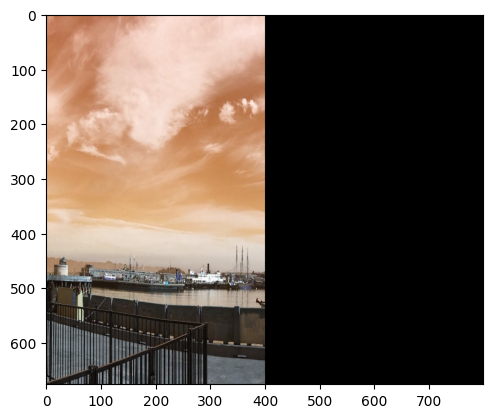

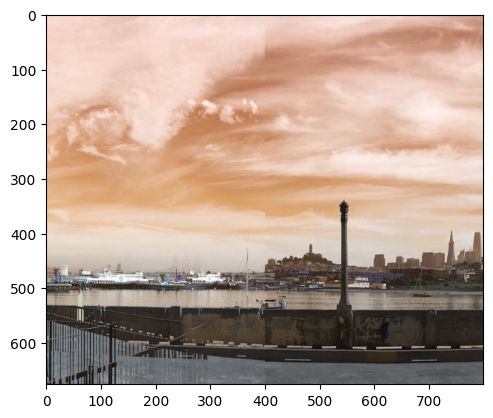

In [91]:
img1 = cv2.imread("pantest/tset2/1.jpg") 
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) 
img2 = cv2.imread("pantest/tset2/2.jpg") 
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) 

lmax1 = imregionalmax(gray1)
lmax2 = imregionalmax(gray2)

h1 = cv2.cornerHarris(gray1, 2, 5, 0.04)
h2 = cv2.cornerHarris(gray2, 2, 5, 0.04)

#for i in range(len(h1)):
#    img1 = cv2.circle(img1,(h1[i][1],h1[i][0]),radius=3,color=(255,0,0), thickness=-1)
#plt.imshow(img1)
#plt.show()

#print(h1)
points1 = jit_amns(h1, 500, lmax1)
points2 = jit_amns(h2, 500, lmax2)

points1 = np.array(points1)
points2 = np.array(points2)

fd1 = fdsc(gray1, points1) 
fd2 = fdsc(gray2, points2) 

kp1, kp2, idx = fmatch(fd1, fd2, points1, points2)
nidx = np.array(idx) 
p1 = np.array(points1)
p2 = np.array(points2)

#plt.imshow(img1)
#plt.show()
#for i in range(len(p1)):
 #   img1 = cv2.circle(img1,(p1[i][1],p1[i][0]),radius=3,color=(255,0,0), thickness=-1)
#plt.imshow(img1)
#plt.show()

#img3 = drawMatches(img1, p1, img2, p2, nidx) 
#cv2.imshow("f", img3) 
#cv2.waitKey(10000) 
#cv2.destroyAllWindows()

#t, i1, i2, idx2 = ransac(kp1, kp2, len(kp1))
#np1 = np.array(i1)
#np2 = np.array(i2)
#ndx = np.array(idx2)

#img3 = drawMatches(img1, np1, img2, np2, ndx) 
#cv2.imshow("f", img3) 
#cv2.waitKey(10000) 
#cv2.destroyAllWindows()
print(t)
h = np.zeros((3,3))
h[0][0] = 0.5
h[1][1] = 1
#h[1][2] = 0.5
#h[2][1] = -0.5
#h[2][2] = 0.866
h[2][2] = 1
print(h)

#img1w = cv2.warpPerspective(img1,h,(int(700),int(700)))
#plt.imshow(img1w)
#plt.show()
#img1w = cv2.warpPerspective(img1,t,(int(1000),int(700)))
#plt.imshow(img1w)
#plt.show()

blend(h, img1, img2)

In [76]:
def function(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    gray = np.float32(gray)
    harris = cv2.cornerHarris(gray, 2, 3, 0.04)
    lmax = imregionalmax(gray)
    corners = jit_amns(harris, 500, lmax)
    return fdsc(image, corners), corners 

In [ ]:
def display(image):
    cv2.imshow("f", image) 
    cv2.waitKey(10000) 
    cv2.destroyAllWindows()

In [ ]:
# homography example (remove this block in the final submission)
src = np.array([
    [0, 0],
    [3, 0],
    [0, 2],
    [3, 2]
])
dest = np.array([
    [10, 10],
    [13, 10],
    [12, 12],
    [15, 12]
])

H = est_homography(src, dest)
print(f"H:\n{H}")
dest2 = apply_homography(H, src)
print(f"recover dest:\n{dest2}")